# Flavor Shifts
## Applying the Shifterator package to ice cream reviews

The Shifterator (https://github.com/ryanjgallagher/shifterator) quantifies differences in two texts/collection of texts by applying information-theoretic metrics to the word frequencies. See the citation below.

> Gallagher, R. J., Frank, M. R., Mitchell, Lewis, Schwartz, A. J., Reagan, A. J., Danforth, C. M., Dodds, P. S.. (2020). Generalized Word Shift Graphs: A Method for Visualizing and Explaining Pairwise Comparisons Between Texts. arXiv preprint 2008.02250.

The ice cream dataset contains over 21,000 reviews of 200+ flavors across 4 brands (Ben & Jerry's, Häagen-Dazs, Breyers, and Talenti). I collected the data from the brand websites. The dataset currently lives on Kaggle (https://www.kaggle.com/tysonpo/ice-cream-dataset).

The purpose of this notebook is to identify which products are successful and interpret why they are successful. We aim to do this using the shifterator. :)

In [2]:
# working with data & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import Counter
import random

# text preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# shifterator
from shifterator import ProportionShift, EntropyShift, JSDivergenceShift

# displaying product images
import cv2

# load data
df = pd.read_csv("ice-cream-dataset-v2/combined/reviews.csv")


Bad key "text.kerning_factor" on line 4 in
C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [12]:
def get_flavor_reviews_as_list(df, text="text", flavor1=None, flavor2=None):
    """
        Load in ice cream reviews data. If flavors (product keys) are specified, then reviews for these flavors are extracted,
        otherwise two flavors are selected randomly.
        
        Input:
            :df (pd.DataFrame): ice cream reviews dataset 
            :text (str): can be either "text" or "title" depending on whether review text or title is desired
            :flavor1, flavor2 (str): product keys, e.g. "0_bj", "14_breyers"
        Output:
            :r1, r2 (np.ndarray): a list of reviews (1 list for each flavor)
    """
    
    if not (flavor1 and flavor2):
        f1, f2 = random.sample(set(df["key"].values), 2)
        if not flavor1:
            flavor1 = f1
        if not flavor2:
            flavor2 = f2
            
    r1 = df.loc[(df["key"]==flavor1) & (df[text].notnull()), text].values
    r2 = df.loc[(df["key"]==flavor2) & (df[text].notnull()), text].values
    
    print("Flavor 1:", flavor1, "Number of reviews:", len(r1))
    print("Flavor 2:", flavor2, "Number of reviews:", len(r2))
    
    return r1, r2

def clean_text(text):
    # split into words
    tokens = word_tokenize(text)

    # convert to lower case
    tokens = [w.lower() for w in tokens]

    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    # filter out stop words and other uninteresting words
    stop_words = set(stopwords.words('english'))
    other = set(["ben", "jerry", "jerrys", "b", "j", "haagendazs", "haagen", "dazs", "breyers", "breyer", "talenti",
                "talentis", "unilever", "unilevercom", "mills", "froneri", "ice", "cream", "gelato"])
    stop_words = stop_words.union(other)
    words = [w for w in words if not w in stop_words]
    
    return words

def prepare_text_from_list(r1, r2):
    text1_clean = clean_text(" ".join(r1))
    text2_clean = clean_text(" ".join(r2))
    
    # make sure the word appears at least a few times in each
    ct1 = dict(Counter(text1_clean))
    ct2 = dict(Counter(text2_clean))
    system_1 = {w:ct1[w] for w in ct1 if ct1[w] > 3 and w in ct2 and ct2[w] > 3} 
    system_2 = {w:ct2[w] for w in ct2 if ct2[w] > 3 and w in ct1 and ct1[w] > 3}
    
    return system_1, system_2

In [8]:
flavor1, flavor2 = ["14_bj", "37_bj"]

r1, r2 = get_flavor_reviews_as_list(df, text="text", flavor1=flavor1, flavor2=flavor2)
system_1, system_2 = prepare_text_from_list(r1, r2)

Flavor 1: 14_bj Number of reviews: 153
Flavor 2: 37_bj Number of reviews: 21521


In [9]:
def make_flavor_shift_plot(ax, titles):
#     shift = JSDivergenceShift(system_1, system_2)
    shift = EntropyShift(system_1, system_2)
    shift.get_shift_graph(system_names=titles, ax=ax, show_plot=False)

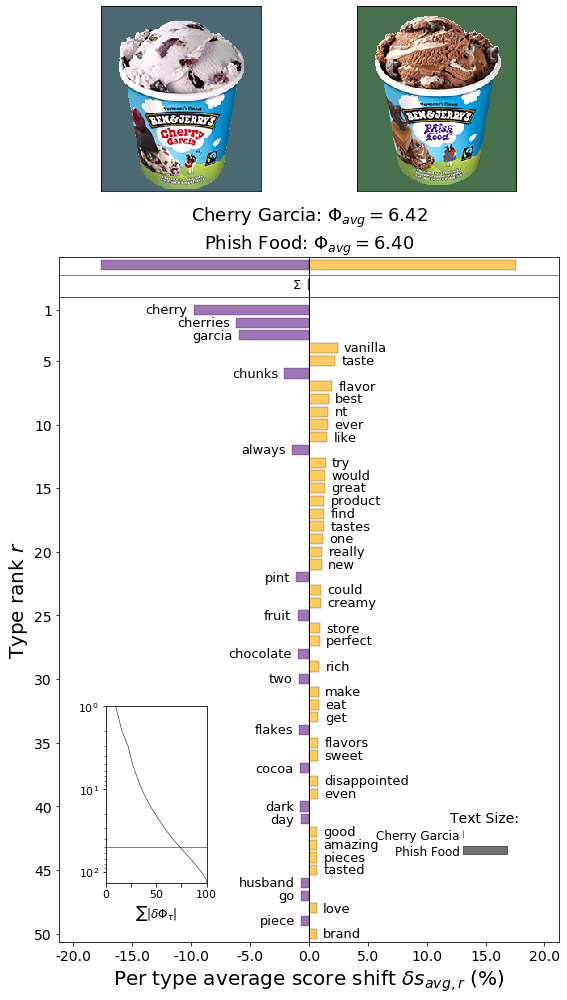

In [10]:
# initialize figure & gridspec
fig = plt.figure(constrained_layout=True, figsize=(8,14))
gs = fig.add_gridspec(4, 2) # fiddle around with number of rows, figsize, spacing, and constrained_layout

# initialize subplot axes
f_ax0 = fig.add_subplot(gs[0, 0])
f_ax1 = fig.add_subplot(gs[0, 1])
f_ax2 = fig.add_subplot(gs[1:, :])

# flavor 1
img1 = cv2.imread("ice-cream-dataset-v2/combined/images/%s.png" % flavor1)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
plt.sca(f_ax0)
plt.imshow(img1)
plt.xticks([])
plt.yticks([])

# flavor 2
img2 = cv2.imread("ice-cream-dataset-v2/combined/images/%s.png" % flavor2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) 
plt.sca(f_ax1)
plt.imshow(img2)
plt.xticks([])
plt.yticks([])

# word shift
make_flavor_shift_plot(f_ax2, titles=["Cherry Garcia", "Phish Food"])

# save/display
plt.savefig("fig1.pdf")
plt.show()

# Scrap work

In [102]:
# product data
prod = pd.read_csv("ice-cream-dataset-v2/combined/products.csv")
prod.loc[prod["name"] == "Phish Food®", "key"] # which key corresponds to Phish Food?

37    37_bj
Name: key, dtype: object

# Idea 2:
- Count word frequencies for words that appear in positive (4 or 5 star) reviews. For each word we compute a score by adjusting its frequency:

1. normalize by its frequency in all positive ice cream reviews over all flavors (to eliminate words like "delicious")
2. normalize by its frequency in all pos+neg reviews for this flavor (to eliminate flavor-specific words "cherry", "garcia")
3. multiply by word sentiment score
4. multiply by star rating

- Repeat for negative reviews and display words

Misc: 
- Involve word sentiment/entropy?
- Do this for 2 flavors?

In [43]:
flavor = '0_bj'
p_all = df.loc[(df["text"].notnull()) & (df["stars"].isin([4,5])), "text"].values
p_flavor = df.loc[(df["key"]==flavor) & (df["text"].notnull()) & (df["stars"].isin([4,5])), "text"].values

n_all = df.loc[(df["text"].notnull()) & (df["stars"].isin([1,2,3])), "text"].values
n_flavor = df.loc[(df["key"]==flavor) & (df["text"].notnull()) & (df["stars"].isin([1,2,3])), "text"].values

pn_flavor = np.concatenate([p_flavor, n_flavor])
p_all.shape, p_flavor.shape, n_all.shape, n_flavor.shape, pn_flavor.shape

((17079,), (118,), (4595,), (90,), (208,))

In [44]:
def clean_text(text):
    # split into words
    tokens = word_tokenize(text)

    # convert to lower case
    tokens = [w.lower() for w in tokens]

    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    # filter out stop words and other uninteresting words
    stop_words = set(stopwords.words('english'))
    other = set(["ben", "jerry", "jerrys", "b", "j", "haagendazs", "haagen", "dazs", "breyers", "breyer", "talenti",
                "talentis", "unilever", "unilevercom", "mills", "froneri", "ice", "cream", "gelato"])
    stop_words = stop_words.union(other)
    words = [w for w in words if not w in stop_words]
    
    return words


def normalize(d):
   factor = 1.0/sum(d.values())
   return {key:d[key]*factor for key in d}

def get_word_freqs(reviews):
    text_clean = clean_text(" ".join(reviews))
    ct = dict(Counter(text_clean))
        
    return normalize(ct) 

In [45]:
p_all = get_word_freqs(p_all)
p_flavor = get_word_freqs(p_flavor)
n_all = get_word_freqs(n_all)
n_flavor = get_word_freqs(n_flavor)
pn_flavor = get_word_freqs(pn_flavor)

In [56]:
p_scores = {}
for w in p_flavor:
    p_scores[w] = p_flavor[w] / (pn_flavor[w])
    
n_scores = {}
for w in n_flavor:
    n_scores[w] = n_flavor[w] / (pn_flavor[w]*n_all[w])

In [59]:
sorted(p_scores.items(), key=lambda x: x[1])

[('excited', 0.13360643301471706),
 ('disappointed', 0.22267738835786172),
 ('worst', 0.2862994993172508),
 ('went', 0.2862994993172508),
 ('salt', 0.31643628871906665),
 ('half', 0.3340160825367926),
 ('pretty', 0.3340160825367926),
 ('actually', 0.3340160825367926),
 ('reviews', 0.3340160825367926),
 ('even', 0.4008192990441511),
 ('wrong', 0.4008192990441511),
 ('supposed', 0.4008192990441511),
 ('recently', 0.4008192990441511),
 ('icecream', 0.4008192990441511),
 ('well', 0.4008192990441511),
 ('ended', 0.4008192990441511),
 ('stopped', 0.4008192990441511),
 ('everything', 0.4008192990441511),
 ('whole', 0.4008192990441511),
 ('bought', 0.4175201031709907),
 ('last', 0.4219150516254222),
 ('around', 0.44535477671572343),
 ('halfway', 0.44535477671572343),
 ('got', 0.44535477671572343),
 ('way', 0.47465443307859995),
 ('nothing', 0.5010241238051889),
 ('saw', 0.5010241238051889),
 ('also', 0.5010241238051889),
 ('guess', 0.5010241238051889),
 ('probably', 0.5010241238051889),
 ('fel